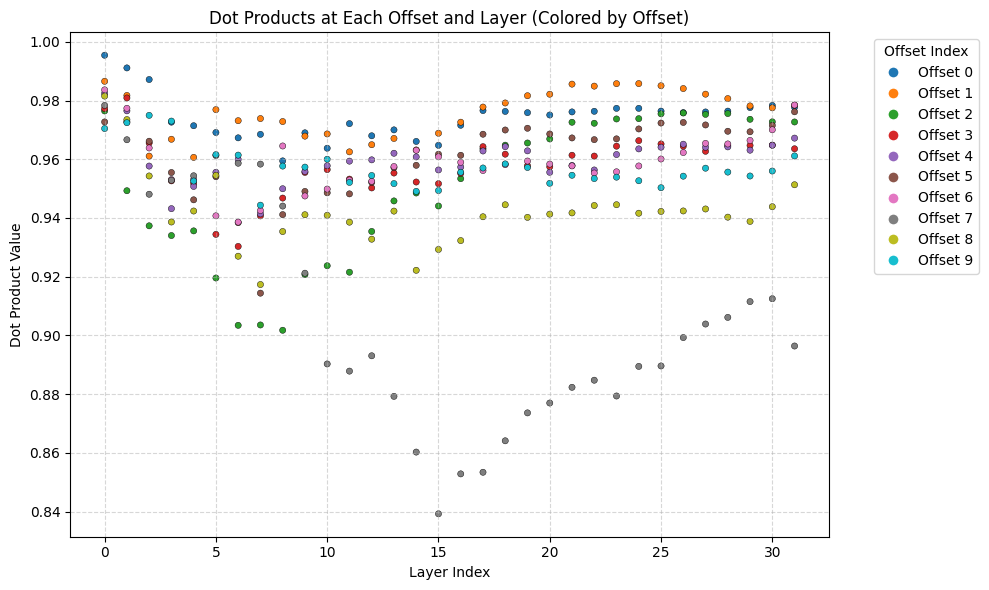

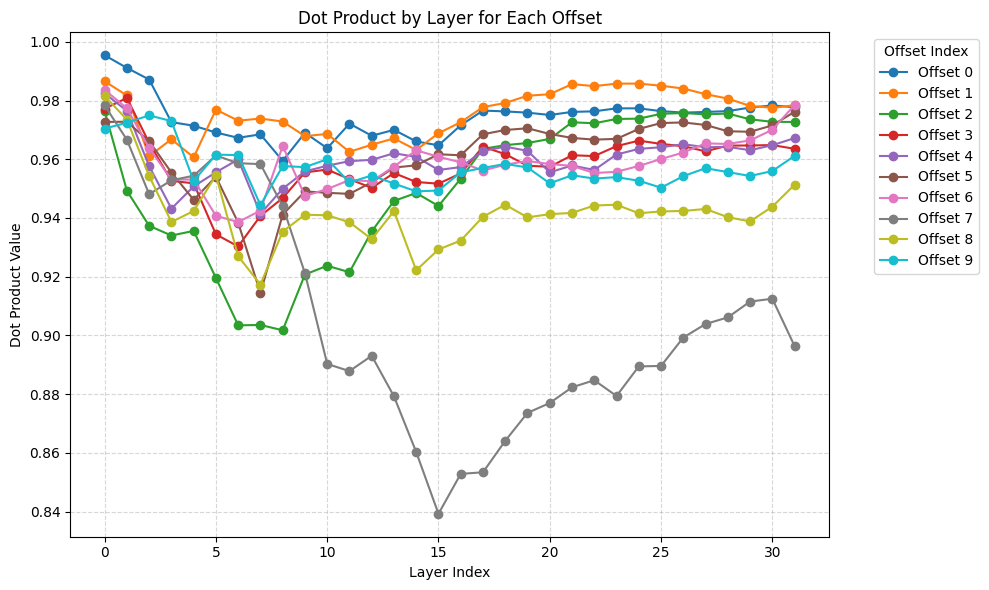

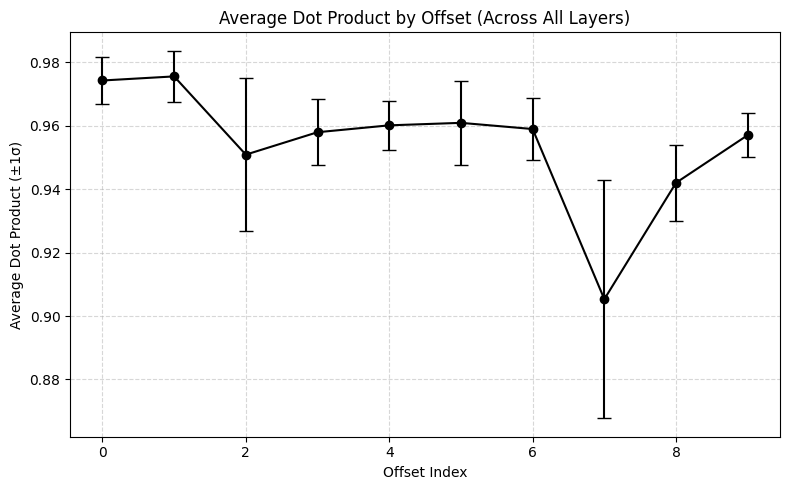

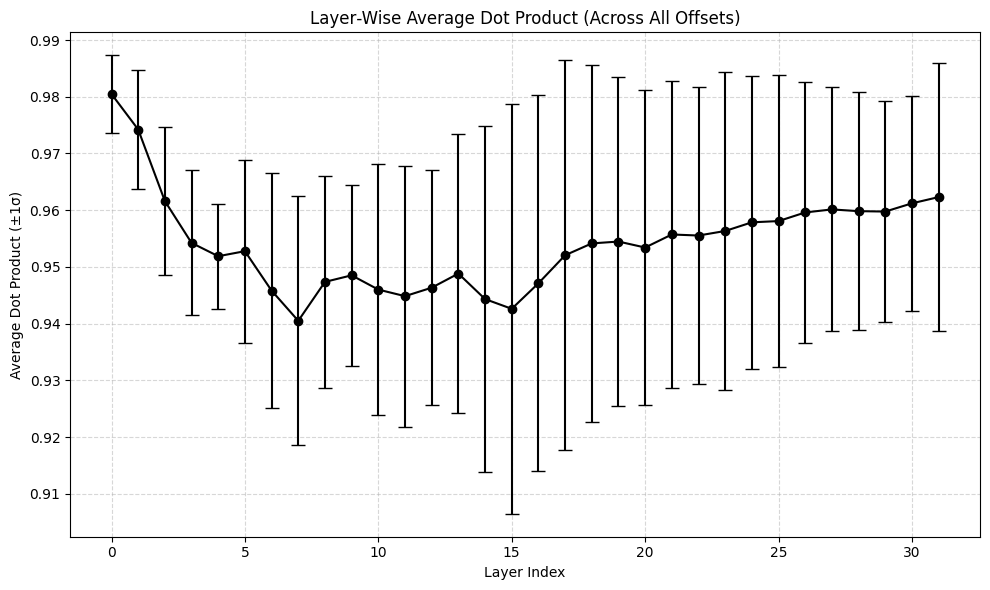

In [21]:
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt

file1 = "../vectors/created_vector/steering_vector_final.pkl"
file2 = "../vectors/test_vectors/selfpreference_from_hackathon_submission_unnorm.pkl"

with open(file1, "rb") as f:
    steering_vectors = pickle.load(f)

with open(file2, "rb") as f:
    loaded_proj = pickle.load(f)

# Compute dot products per layer & offset
dot_products = {}
for layer_idx, steering_list in steering_vectors.items():
    proj_list = loaded_proj.get(layer_idx)
    if proj_list is None or len(proj_list) != len(steering_list):
        continue

    dot_products[layer_idx] = []
    for offset_idx, steering_vec in enumerate(steering_list):
        proj_vec = proj_list[offset_idx]

        steering_flat = steering_vec.view(-1)
        proj_flat = proj_vec.view(-1)
        if steering_flat.shape != proj_flat.shape:
            raise RuntimeError(
                f"Shape mismatch at layer {layer_idx}, offset {offset_idx}: "
                f"{steering_flat.shape} vs. {proj_flat.shape}"
            )

        dp_value = torch.dot(steering_flat, proj_flat).item()
        dot_products[layer_idx].append(dp_value)

# Flatten into arrays for the scatter plot
layers_list, dots_list, offsets_list = [], [], []
for layer_idx, dp_list in dot_products.items():
    for offset_idx, dp_val in enumerate(dp_list):
        layers_list.append(layer_idx)
        dots_list.append(dp_val)
        offsets_list.append(offset_idx)

layers_arr  = np.array(layers_list)
dots_arr    = np.array(dots_list)
offsets_arr = np.array(offsets_list, dtype=int)

# Identify unique offsets (should be 0..9) and build a 10‐color colormap
unique_offsets = np.unique(offsets_arr)          # e.g. array([0,1,2,...,9])
num_offsets    = len(unique_offsets)              # 10
cmap           = plt.get_cmap('tab10', num_offsets)

# Directly use offsets_arr (0..9) as indices into tab10
colors = cmap(offsets_arr)

# === Scatter plot: each point colored by its offset ===
plt.figure(figsize=(10, 6))
plt.scatter(layers_arr, dots_arr, c=colors, s=20, edgecolors='k', linewidths=0.3)
plt.xlabel("Layer Index")
plt.ylabel("Dot Product Value")
plt.title("Dot Products at Each Offset and Layer (Colored by Offset)")
plt.grid(True, linestyle='--', alpha=0.5)

# Build a legend patch for each offset 0..9 in the same order/colors
legend_patches = []
for offset in unique_offsets:
    legend_patches.append(
        plt.Line2D(
            [0], [0],
            marker='o',
            color='w',
            markerfacecolor=cmap(int(offset)),
            markersize=8,
            label=f"Offset {offset}"
        )
    )

plt.legend(
    handles=legend_patches,
    title="Offset Index",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)
plt.tight_layout()
plt.show()

# === Line plot: dot‐product vs layer, one line per offset ===
plt.figure(figsize=(10, 6))
for offset in unique_offsets:
    x_vals, y_vals = [], []
    for layer_idx in sorted(dot_products.keys()):
        # Now index directly by offset (0..9), not offset-1
        if offset < len(dot_products[layer_idx]):
            x_vals.append(layer_idx)
            y_vals.append(dot_products[layer_idx][offset])
    plt.plot(
        x_vals, y_vals,
        marker='o',
        linestyle='-',
        label=f"Offset {offset}",
        color=cmap(int(offset))
    )

plt.xlabel("Layer Index")
plt.ylabel("Dot Product Value")
plt.title("Dot Product by Layer for Each Offset")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Offset Index", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# === Error‐bar plot: average ± std across layers for each offset ===
avg_by_offset = []
std_by_offset = []
for offset in unique_offsets:
    vals = []
    for layer_idx in dot_products.keys():
        if offset < len(dot_products[layer_idx]):
            vals.append(dot_products[layer_idx][offset])
    avg_by_offset.append(np.mean(vals))
    std_by_offset.append(np.std(vals))

plt.figure(figsize=(8, 5))
plt.errorbar(unique_offsets, avg_by_offset, yerr=std_by_offset, fmt='-o', capsize=5, color='black')
plt.xlabel("Offset Index")
plt.ylabel("Average Dot Product (±1σ)")
plt.title("Average Dot Product by Offset (Across All Layers)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === Error‐bar plot: average ± std across offsets for each layer ===
layer_indices = sorted(dot_products.keys())
layer_avgs    = [np.mean(dot_products[L]) for L in layer_indices]
layer_stds    = [np.std(dot_products[L])  for L in layer_indices]

plt.figure(figsize=(10, 6))
plt.errorbar(layer_indices, layer_avgs, yerr=layer_stds, fmt='-o', capsize=5, color='black')
plt.xlabel("Layer Index")
plt.ylabel("Average Dot Product (±1σ)")
plt.title("Layer‐Wise Average Dot Product (Across All Offsets)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
